# Novel Strategy: Kmeans + SVR

### Import packages

In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
    StandardScaler,
)
from sklearn.compose import make_column_transformer

from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.metrics import silhouette_score


import umap
import altair as alt
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

### Read and process data 

In [2]:
data = pd.read_csv("../data/processed/clean_data.csv")
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)
numeric_features = [
    "lat",
    "long",
    "alt",
    "tmax",
    "tmin",
    "prcp",
    "agdd_winter",
    "tmax_winter",
    "prcp_winter",
    "co2_percapita",
    "co2_emission",
    "year"
]
target = "bloom_doy"

In [3]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]


X_train_cluster = X_train.drop(columns = ['country', 'city'])


X_train_cluster

,year,lat,long,alt,tmax,tmin,prcp,agdd_winter,tmax_winter,tmin_winter,prcp_winter,co2_percapita
543,1978,32.694722,128.826944,25.10,20.325205,12.798082,5.719178,739.950000,11.782258,4.555415,27.667051,7.7804
1837,1974,34.693889,135.827778,104.40,19.346575,9.348219,4.235616,325.200000,8.213902,-1.001651,11.549539,8.2353
1334,1987,34.228889,135.164167,13.90,20.998904,12.703836,2.665753,686.500000,11.879339,3.333525,15.900538,7.3333
5280,2000,44.017778,144.279722,37.58,9.920189,2.465829,6.365584,0.000000,-2.088259,-10.401716,47.284615,9.9148
3921,1955,38.261944,140.896667,38.85,16.763014,8.625753,3.580822,250.100000,6.604455,-1.522350,17.333717,1.5938
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1965,37.131667,140.215000,354.95,15.622192,6.026027,3.453973,126.500000,5.278072,-3.666820,12.403994,3.9257
5191,2006,43.330556,145.585556,25.20,10.205956,3.354950,3.100548,6.900000,-0.433043,-7.158170,13.039171,9.8687
5226,1974,43.756944,142.372222,119.80,10.850959,1.470411,3.080822,6.100000,-2.359831,-10.686022,18.035714,8.2353
5390,1999,46.603092,10.421956,1390.00,14.700000,2.898381,4.659859,34.992174,1.374517,-4.858245,15.957830,6.2468


### Scale data using StandardScaler()

In [4]:
scaler = StandardScaler()
preprocess_X = pd.DataFrame(scaler.fit_transform(X_train_cluster), columns = X_train_cluster.columns)
preprocess_X

,year,lat,long,alt,tmax,tmin,prcp,agdd_winter,tmax_winter,tmin_winter,prcp_winter,co2_percapita
0,-0.452625,-0.878378,0.061299,-0.345027,0.534049,0.662392,-0.099643,1.551007,0.732090,0.822957,-0.285828,0.101709
1,-0.666980,-0.459201,0.249723,0.170610,0.295408,-0.118968,-0.376512,0.020524,0.035981,-0.178131,-0.807269,0.255931
2,0.029674,-0.556700,0.231862,-0.417853,0.698332,0.641046,-0.669487,1.353769,0.751029,0.602837,-0.666504,-0.049868
3,0.726328,1.495794,0.477202,-0.263878,-2.003237,-1.677760,0.020993,-1.179507,-1.973748,-1.871523,0.348850,0.825322
4,-1.685167,0.288934,0.386149,-0.255620,-0.334599,-0.282599,-0.498712,-0.256605,-0.277987,-0.271933,-0.620137,-1.995694
...,...,...,...,...,...,...,...,...,...,...,...,...
4322,-1.149279,0.051942,0.367802,1.799774,-0.612791,-0.871411,-0.522386,-0.712706,-0.536736,-0.658253,-0.779626,-1.205125
4323,1.047861,1.351700,0.512348,-0.344377,-1.933552,-1.476383,-0.588343,-1.154046,-1.650851,-1.287208,-0.759076,0.809693
4324,-0.666980,1.441104,0.425863,0.270746,-1.776267,-1.903212,-0.592025,-1.156998,-2.026725,-1.922740,-0.597425,0.255931
4325,0.672739,2.037872,-3.125503,8.530036,-0.837670,-1.579792,-0.297338,-1.050382,-1.298235,-0.872884,-0.664650,-0.418217


### Identify the best k using Elbow plot 

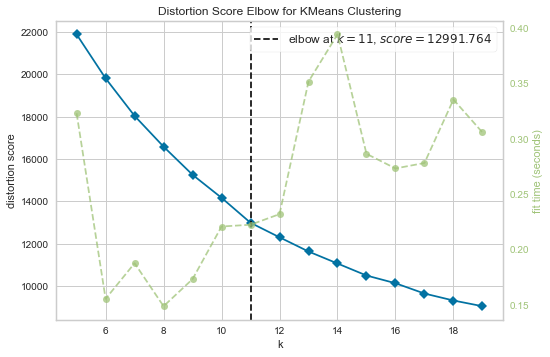

In [5]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(5, 20))

visualizer.fit(preprocess_X)  # Fit the data to the visualizer
visualizer.show();

In [6]:
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(preprocess_X)
preprocess_X["cluster"] = kmeans.predict(preprocess_X)


### Visualize clusters

In [7]:
values, counts = np.unique(preprocess_X["cluster"] , return_counts=True)
count_df = pd.DataFrame({
    'cluster labels': values,
    'counts': counts
})


alt.Chart(count_df, title = "Some clusters have very few samples").mark_bar().encode(
    x = "cluster labels",
    y = "counts"
)

alt.Chart(...)

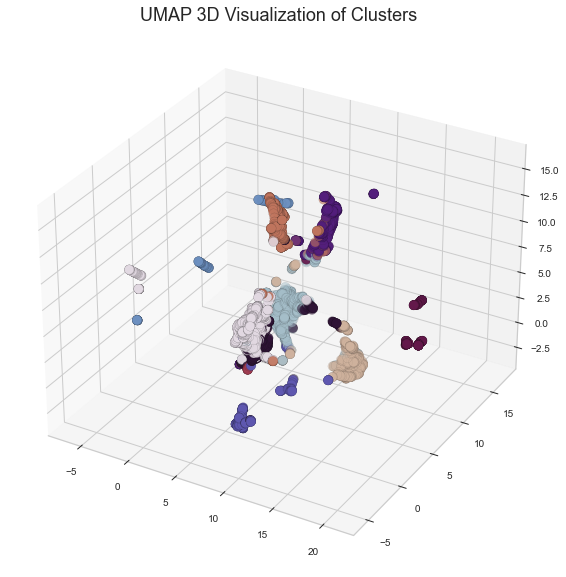

In [8]:
data_plot = preprocess_X.drop(columns=["cluster"])
fit = umap.UMAP(n_neighbors=11,n_components=3, min_dist=0.1, metric='euclidean', random_state=42)
u = fit.fit_transform(data_plot)
color = kmeans.labels_
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], c= color, s=90, cmap="twilight", edgecolors="k", linewidths=0.1)
plt.title("UMAP 3D Visualization of Clusters", fontsize=18);
plt.savefig("../results/cluster.svg")

### Train SVR model per cluster

In [9]:
y_train_new = pd.DataFrame(y_train).reset_index()

In [10]:
n_clusters=11
model = SVR(C=1000, epsilon=1)
cluster_svr = []

for i in range(n_clusters):
    cluster_X = preprocess_X[preprocess_X['cluster'] == i]
    index = np.array(preprocess_X[preprocess_X['cluster'] == i].index)
    lookup = y_train_new.loc[index]
    cluster_y = np.array(lookup['bloom_doy'])
    cluster_svr.append(model.fit(cluster_X.drop(columns = ['cluster']), cluster_y))

In [11]:
X_test, y_test = test_df.drop(columns=[target, 'country', 'city']), test_df[target]

In [12]:
preprocess_X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [13]:
result = []
clusters_pred = kmeans.predict(preprocess_X_test)
for i, j in enumerate(clusters_pred):
    result.append(cluster_svr[clusters_pred[i]].predict(pd.DataFrame(preprocess_X_test.loc[j]).T))
pred = pd.DataFrame(result, columns = ["y_test_pred"]) 
pred["cluster"] = clusters_pred
pred

,y_test_pred,cluster
0,86.215086,6
1,75.921180,1
2,75.921180,1
3,75.921180,1
4,98.035987,0
...,...,...
1850,91.875027,5
1851,102.776231,9
1852,92.489383,2
1853,98.035987,0


### Evaluate performance

In [14]:
y_test_result = pd.DataFrame(y_test).reset_index().drop(columns = ['index'])
results = y_test_result.join(pred)
results['difference'] = results['y_test_pred'] - results['bloom_doy']
results

,bloom_doy,y_test_pred,cluster,difference
0,118,86.215086,6,-31.784914
1,92,75.921180,1,-16.078820
2,103,75.921180,1,-27.078820
3,106,75.921180,1,-30.078820
4,92,98.035987,0,6.035987
...,...,...,...,...
1850,98,91.875027,5,-6.124973
1851,96,102.776231,9,6.776231
1852,100,92.489383,2,-7.510617
1853,90,98.035987,0,8.035987


In [15]:
rmse = (sum(results["difference"]**2) / len(results))**0.5
rmse

27.241442457709088